# Vehicle detection and tracking

This juypter notebook contains a pipeline to detect vehicles and tracks them in the image frame.

## Init

In [92]:
import numpy as np
import time
import glob
import cv2
import matplotlib.pyplot as plt
#%matplotlib nbagg
%matplotlib inline

import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from skimage.feature import hog
from scipy.ndimage.measurements import label

from IPython.core.display import display, HTML
display(HTML(
"""<style>
    div#notebook-container    { width: 70%; }
    div#menubar-container     { width: 70%; }
    div#maintoolbar-container { width: 70%; }
</style>"""))

# pretty formatting of np float arrays
float_formatter = lambda x: "%10.5f" % x
np.set_printoptions(formatter={'float_kind' : float_formatter})



#############################################################################
# Constants and variables
#############################################################################

# Small dataset for testing
path_notcar_small = "../non-vehicles_smallset/"
path_car_small    = "../vehicles_smallset/"

# Big dataset for actual usage
path_car_big    = "../non-vehicles/"
path_notcar_big = "../vehicles/"

path_test_imgs   = "test_images/"
path_output_imgs = "output_images/" 

## Helper functions

In [111]:
# Draw boxes in an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy


def convert_color(img, colorspace="YCrCb"):
    if colorspace == "HSV":
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif colorspace == "LUV":
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif colorspace == "HLS":
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif colorspace == "YUV":
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif colorspace == "YCrCb":
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    return feature_image


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Use skimage.hog() to get both features and a visualization
    if vis:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                          visualise=vis, feature_vector=feature_vec, block_norm="L2-Hys")

        return features, hog_image
        
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
              cells_per_block=(cell_per_block, cell_per_block), visualise=vis, transform_sqrt=False,
              feature_vector=feature_vec, block_norm="L2-Hys")

        return features


# updated 'extract_features' function 
def extract_features(imgs, color_space="RGB", spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        if file.endswith("*.png"):
            image *= 255
            
        # apply color conversion if other than 'RGB'
        if color_space != "RGB":
            feature_image = convert_color(img, color_space)
        else:
            feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == -1:
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)

        features.append(np.concatenate(file_features))

    return features


# Define a function you will pass an image and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a function to extract features from a single image window
# This function is very similar to extract_features() just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8,
                        cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):    
    # Define an empty list to receive features
    img_features = []
    
    # Apply color conversion if other than 'RGB'
    if color_space != "RGB":
        feature_image = convert_color(img, color_space)
    else:
        feature_image = np.copy(img)      
        
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == -1:
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell,
                                                     cell_per_block, vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell,
                                            cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    return np.concatenate(img_features)


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, colorspace, yrange, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[yrange[0]:yrange[1],:,:]
    if colorspace != "RGB":
        ctrans_tosearch = convert_color(img_tosearch, colorspace)
    else:
        ctrans_tosearch = np.copy(img_tosearch)

    if scale != 1.0:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1, ch2, ch3 = [ctrans_tosearch[:,:,i] for i in range(3)]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1, hog2, hog3 = [get_hog_features(ch, orient, pix_per_cell, cell_per_block, feature_vec=False) for ch in [ch1, ch2, ch3]]
        
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get features
            spatial_features = bin_spatial(subimg, size=spatial_size).reshape(1,-1)
            hist_features    = color_hist(subimg, nbins=hist_bins).reshape(1,-1)
            hog_features     = hog_features.reshape(1,-1)

            # Scale features and make a prediction
            X = np.hstack((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(X)    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw  = np.int(window*scale)
                bbox      = ((xbox_left, ytop_draw+yrange[0]), (xbox_left+win_draw,ytop_draw+win_draw+yrange[0]))
                bboxes.append(bbox)
                cv2.rectangle(draw_img, bbox[0], bbox[1],(0,0,255),6) 
                
    return draw_img, bboxes


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = np.array(img).shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = np.array(img).dtype
    # Return data_dict
    return data_dict

## Visualizing HOG features on images

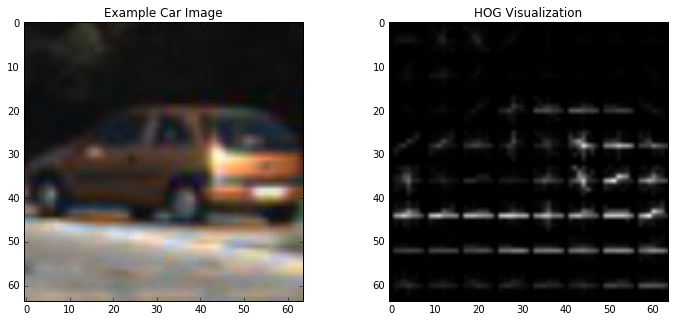

In [61]:
dataset="small" # "small" or "big"

if dataset == "small":
    images_cars    = glob.glob(path_car_small + "**/*.jpeg", recursive=True)
    images_notcars = glob.glob(path_notcar_small + "**/*.jpeg", recursive=True)
else:
    images_cars = glob.glob(path_car_big + "**/*.png", recursive=True)
    images_notcars = glob.glob(path_notcar_big + "**/*.png", recursive=True)

car_ind    = np.random.randint(0, len(images_cars))
notcar_ind = np.random.randint(0, len(images_notcars))
    
# Read in random car/not-car images
car_image = mpimg.imread(images_cars[car_ind])

gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient          = 12
pix_per_cell    = 8
cell_per_block  = 8

# Call function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

## Train SVM classifier on dataset
### Dataset selection, exploration and feature extraction

In [108]:
dataset="small" # "small" or "big"

if dataset == "small":
    images_cars    = glob.glob(path_car_small + "**/*.jpeg", recursive=True)
    images_notcars = glob.glob(path_notcar_small + "**/*.jpeg", recursive=True)
else:
    images_cars = glob.glob(path_car_big + "**/*.png", recursive=True)
    images_notcars = glob.glob(path_notcar_big + "**/*.png", recursive=True)


# Reduce the sample size
sample_size = 5000
cars = images_cars #[0:sample_size]
notcars = images_notcars #[0:sample_size]

data_info = data_look(images_cars, images_notcars)

print('Your function returned a count of', data_info["n_cars"], ' cars and', data_info["n_notcars"], ' non-cars')
print('of size: ', data_info["image_shape"], ' and data type:', data_info["data_type"])


### Tweak these parameters and see how the results change.
colorspace     = "RGB"
orient         = 9  # HOG orientations
pix_per_cell   = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel    = -1 # Can be 0, 1, 2, or -1 for all channels
spatial_size   = (16, 16) # Spatial binning dimensions
hist_bins      = 16    # Number of histogram bins
spatial_feat   = True # Spatial features on or off
hist_feat      = True # Histogram features on or off
hog_feat       = True # HOG features on or off
y_start_stop   = [400, 700] # Min and max in y to search in slide_window()
scale          = 1.0

t=time.time()
car_features    = extract_features(cars, color_space=colorspace, spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print("It took {:0.2f} seconds to extract features...".format(t2-t))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8
spatial_features.shape:  (768,)
hist_features.shape:     (48,)
hog_features.shape:      (5292,)
spatial_features.shape:  (768,)
hist_features.shape:     (48,)
hog_features.shape:      (5292,)
It took 17.60 seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


### Training classifier and testing accuracy on test set

In [109]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print("It took {:0.2f} seconds to train SVC...".format(t2-t))

# Check the score of the SVC
score = svc.score(X_test, y_test)
print("Test Accuracy of SVC = {:0.2f}".format(score))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
predictions = svc.predict(X_test[0:n_predict])
print("My SVC predicts: ", predictions)
print("For labels:      ", y_test[0:n_predict])
t2 = time.time()
print("It took {:0.4f} seconds to predict {} labels with SVC".format(t2-t, n_predict))

It took 1.76 seconds to train SVC...
Test Accuracy of SVC = 0.97
My SVC predicts:  [   0.00000    1.00000    0.00000    0.00000    1.00000    0.00000
    1.00000    1.00000    1.00000    0.00000]
For labels:       [   0.00000    1.00000    0.00000    0.00000    1.00000    0.00000
    1.00000    1.00000    1.00000    0.00000]
It took 0.0013 seconds to predict 10 labels with SVC


### Testing on example images by drawing bounding boxes around vehicles

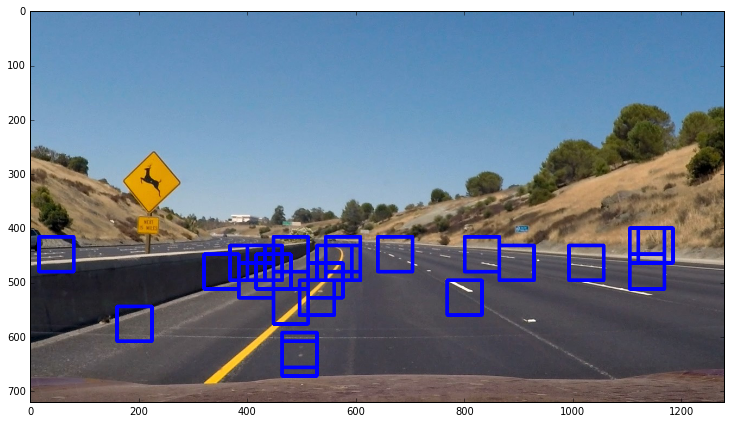

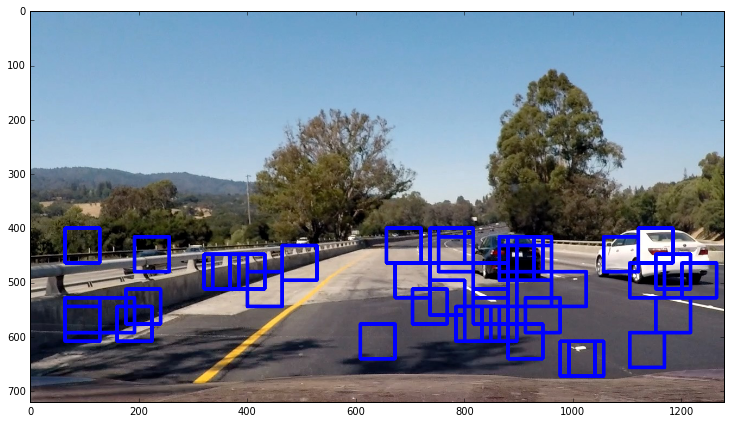

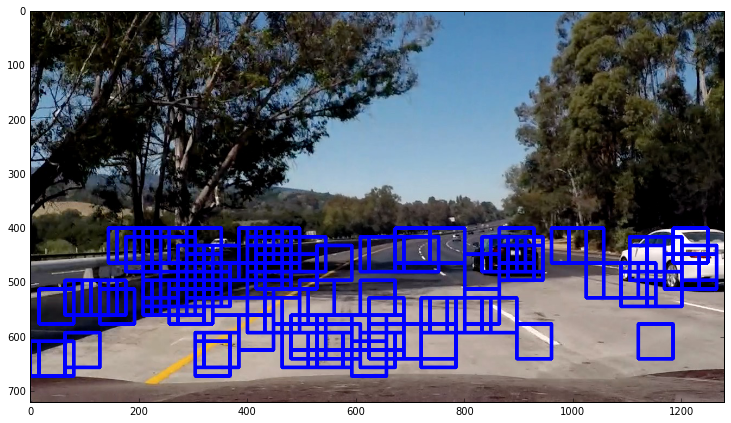

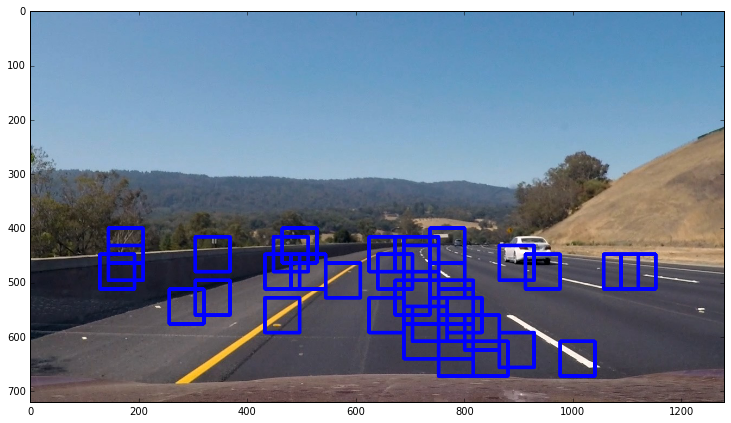

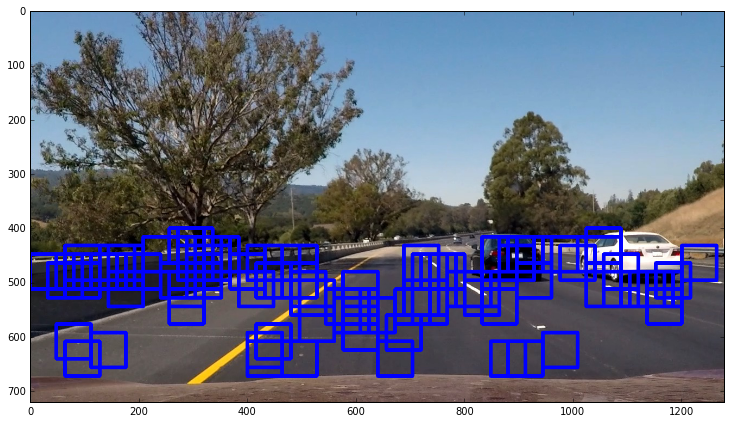

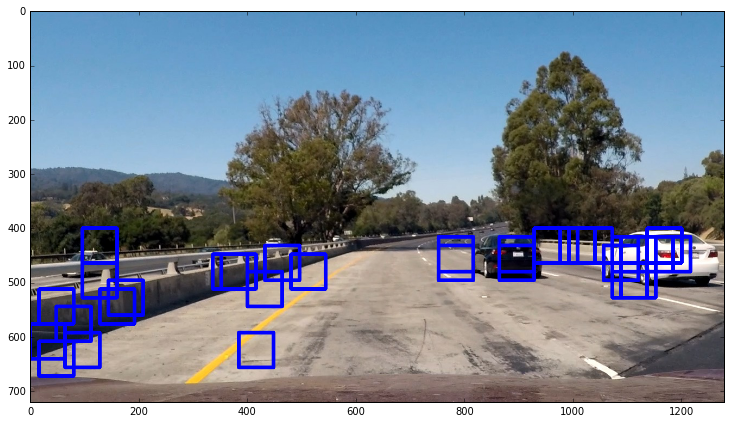

In [112]:
image_names = glob.glob(path_test_imgs+"*.jpg")
for image_name in image_names:
    image = mpimg.imread(image_name)
    out_img, bboxes = find_cars(image, colorspace, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    fig = plt.figure(figsize=(13,7))
    plt.imshow(out_img)
    plt.show()